# Bubble Correlations

In [1]:
%matplotlib inline

In [2]:
import os,sys
from bubble_correlations import *
from experiment import *
from plotting import *

In [3]:
def get_numdens(type, PositiveTargets, NegativeTargets):
    if type == 0:
        allTargets = PositiveTargets + NegativeTargets
        nBubs = np.vectorize(len, otypes=[float])(allTargets)
    elif type == 1:
        allTargets = PositiveTargets + NegativeTargets
        nBubs = np.vectorize(lambda x: len(x) + 1, otypes=[float])(allTargets)
    elif type == 2:
        allTargets = [np.asarray(PositiveTargets[sim].tolist() + NegativeTargets[sim].tolist()) for sim in range(len(PositiveTargets))]
        nBubs = np.vectorize(len, otypes=[float])(allTargets)

    nSims = len(allTargets)
    simVol = nLat * nTime
    return allTargets, sum(nBubs) / nSims / simVol

def correlator(allTargets, R, RR, T, TT):
    corrfunc = []
    for sim, coords in enumerate(allTargets):
        nBubbles = len(coords)
        count = 0.

        if nBubbles>0:
            for ind in range(nBubbles):
                bdt = coords[ind, 0] - coords[:, 0]
                bdx = np.abs(coords[ind, 1] - coords[:, 1])
                bdx[bdx > nLat//2] = nLat - bdx[bdx > nLat//2]
                count += len([l for l, (bx, bt) in enumerate(zip(bdx, bdt)) if (R <= bx < RR and T <= bt < TT)])
            corrfunc.append(count / nBubbles)
    return np.nanmean(corrfunc)

def mixed_correlator(PositiveTargets, NegativeTargets, R, RR, T, TT):
    corrfunc = []
    for sim, (poscoords, negcoords) in enumerate(zip(PositiveTargets, NegativeTargets)):
        nPosBubbles, nNegBubbles = len(poscoords), len(negcoords)
        ncount, pcount = 0., 0.

        if nNegBubbles>0:
            for bubloc in range(nPosBubbles):
                pbdt = poscoords[bubloc,0] - negcoords[:,0]
                pbdx = np.abs(poscoords[bubloc,1] - negcoords[:,1])
                pbdx[pbdx > nLat//2] = nLat - pbdx[pbdx > nLat//2]
                ncount += len([l for l, (bx, bt) in enumerate(zip(pbdx, pbdt)) if (R <= bx < RR and T <= bt < TT)])
            corrfunc.append( ncount / (nNegBubbles + 1.))

        if nPosBubbles>0:
            for bubloc in range(nNegBubbles):
                nbdt = negcoords[bubloc,0] - poscoords[:,0]
                nbdx = np.abs(negcoords[bubloc,1] - poscoords[:,1])
                nbdx[nbdx > nLat//2] = nLat - nbdx[nbdx > nLat//2]
                pcount += len([l for l, (bx, bt) in enumerate(zip(nbdx, nbdt)) if (R <= bx < RR and T <= bt < TT)])
            corrfunc.append( pcount / (nPosBubbles + 1.))
    return np.nanmean(corrfunc)

def empirical_corr_and_err(corrtype, minS, maxS, multi, tcheck, filter, nBatch, T, TT):
    PositiveTargets, NegativeTargets = import_all_data(minS, maxS, multi, tcheck, filter)

    batches = np.arange(0, nBatch) * len(PositiveTargets) // nBatch
    counter = []
    for ind, (smin, smax) in enumerate(zip(batches[:-1:], batches[1:])):
        posTGS = PositiveTargets[smin:smax]
        negTGS = NegativeTargets[smin:smax]
        allTGS, nDens = get_numdens(corrtype, posTGS, negTGS)

        corrvec = - np.ones(len(xrange))
        for ind, (R, RR) in enumerate(zip(xrange[:-1:], xrange[1:])):
            area = 2. * np.abs(RR-R) * np.abs(TT-T)
            
            if corrtype != 1:
                corrvec[ind] = correlator(allTGS, R, RR, T, TT)
            else:
                corrvec[ind] = mixed_correlator(posTGS, negTGS, R, RR, T, TT)

        counter.append(corrvec / area / nDens - 1.)
    return np.nanmean(counter, axis=0), np.nanstd(counter, axis=0)/np.sqrt(nBatch)

def spacetime_correlator(corrtype, minS, maxS, xrange, trange, multi, tcheck, filter):
    PositiveTargets, NegativeTargets = import_all_data(minS, maxS, multi, tcheck, filter)
    allTargets, nDens = get_numdens(corrtype, PositiveTargets, NegativeTargets)

    matrix = - np.ones((len(trange), len(xrange)))
    for tind, (T, TT) in enumerate(zip(trange[:-1:], trange[1:])):
        for xind, (R, RR) in enumerate(zip(xrange[:-1:], xrange[1:])):
            area = 2. * np.abs(RR-R) * np.abs(TT-T)

            if corrtype != 1:
                corr_func = correlator(allTargets, R, RR, T, TT)
            else:
                corr_func = mixed_correlator(PositiveTargets, NegativeTargets, R, RR, T, TT)

            matrix[tind, xind] = corr_func / area / nDens - 1.
    return matrix

### One-Dimensional Correlators 

In [16]:
xmin = 0
xmax = 512
Tmin = -5
Tmax = 5
nBatch = 4

smoothing = filter_size
radiusBubble = filter_size

In [17]:
tmin = -4
tmax = 5

xstep = 6
tstep = 10

xrange = np.arange(xmin, xmax+1, xstep)
trange = np.arange(tmin, tmax+1, tstep)

In [18]:
print(minSim, maxSim)

0 1000


In [7]:
for multiplier in list_multiplier:
    for corrtype in [0,1,2]:
        print(corrtype)
        datapath = data_file_1D(corrtype, xstep, np.abs(Tmax-Tmin), multiplier, smoothing)
        if not os.path.exists(datapath+'.npy'):
            print(datapath+'.npy')
            corr_data = empirical_corr_and_err(corrtype, minSim, maxSim, multiplier, tcheck, smoothing, nBatch, Tmin, Tmax)
            np.save(datapath, corr_data)
print('Done')

0
/gpfs/dpirvu/bubble_correlations/corr1d_type0_xstep6_deltat10_multiplier0.0_filter5.0000.npy
1
/gpfs/dpirvu/bubble_correlations/corr1d_type1_xstep6_deltat10_multiplier0.0_filter5.0000.npy
2
/gpfs/dpirvu/bubble_correlations/corr1d_type2_xstep6_deltat10_multiplier0.0_filter5.0000.npy
0
/gpfs/dpirvu/bubble_correlations/corr1d_type0_xstep6_deltat10_multiplier0.5_filter5.0000.npy
1
/gpfs/dpirvu/bubble_correlations/corr1d_type1_xstep6_deltat10_multiplier0.5_filter5.0000.npy
2
/gpfs/dpirvu/bubble_correlations/corr1d_type2_xstep6_deltat10_multiplier0.5_filter5.0000.npy
0
/gpfs/dpirvu/bubble_correlations/corr1d_type0_xstep6_deltat10_multiplier1.0_filter5.0000.npy
1
/gpfs/dpirvu/bubble_correlations/corr1d_type1_xstep6_deltat10_multiplier1.0_filter5.0000.npy
2
/gpfs/dpirvu/bubble_correlations/corr1d_type2_xstep6_deltat10_multiplier1.0_filter5.0000.npy
Done


In [19]:
def plot_comparison3(ax, xrange, deltat, zzz, multiplier, threshold, filter, fil):
    xlist = xrange/radiusBubble
    for dd, corrtype in enumerate([0,1,2]):
        print(dd)
        datapath = data_file_1D(corrtype, xrange[-1]-xrange[-2], deltat, multiplier, smoothing)
        rivolo = np.load(datapath+'.npy')
        rivolo[:2,0], rivolo[:2,1] = -1.,0.

        lab = r'$\phi_0$ = {:.2f}'.format(phi0)+r', $\lambda$ = '+str(lamb)
        markers, caps, bars = ax[corrtype].errorbar(xlist, rivolo[0], \
                yerr=rivolo[1], color=tabl[dd], ecolor=tabl[dd], ls=['-','-.','--',':','-'][zzz], ms=4, elinewidth=4, label=lab)

        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
    handles, labels = ax[0].get_legend_handles_labels()
    handles = [h[0] for h in handles]
    tit = r'$\bar{\phi}_t$'+' = {:.2f}'.format(threshold)+(r', $R_0=\bar{R}/{%s}$'%(fil) if fil != 1 else r', $R_0=\bar{R}$')
    ax[0].legend(handles, labels, numpoints=1, title=tit, fancybox=True, loc='upper right')
    for aa, axx in enumerate(ax):
        axx.grid(alpha=0.5, linestyle='-', linewidth=0.5)
        axx.set_xlabel(r'$r/\bar{R}$')
        axx.set_ylabel(list_title_type[aa])
        axx.set_xlim(0.,xlist[-10])
        axx.set_ylim(-10, 20)
    return ax

0
1
2
0
1
2
0
1
2


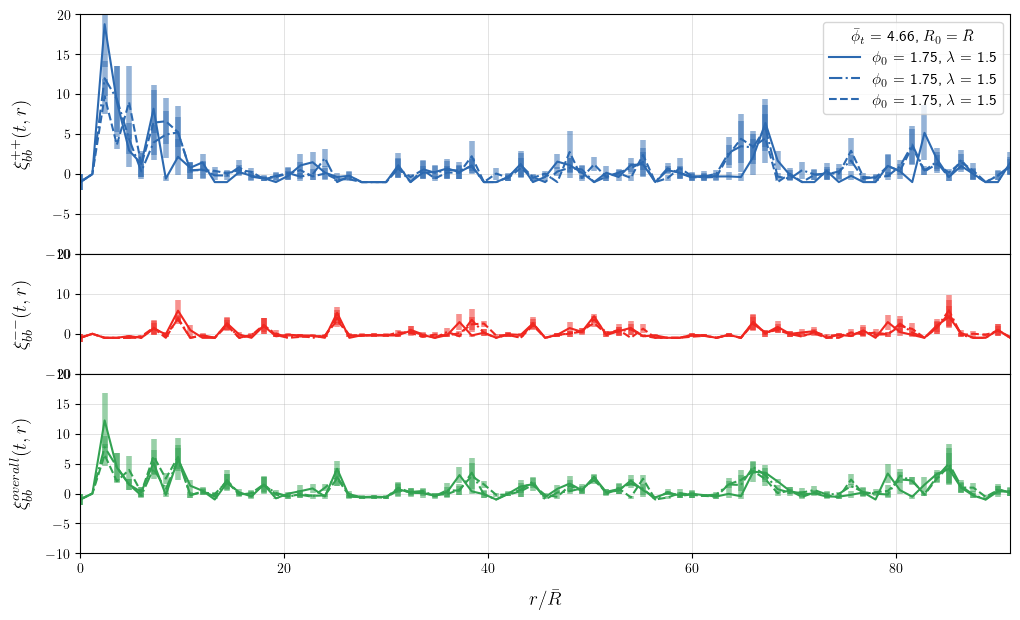

In [20]:
if True:
    fig = plt.figure(figsize=(12,7))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2,1,1.5]) 
    ax = [[],[],[]]; ax[0] = plt.subplot(gs[0])
    ax[1] = plt.subplot(gs[1], sharex = ax[0])
    ax[2] = plt.subplot(gs[2], sharex = ax[1])
    plt.setp(ax[0].get_xticklabels(), visible = False)
    plt.setp(ax[1].get_xticklabels(), visible = False)
    plt.subplots_adjust(hspace=.0)

    for zzz, (multiplier, threshold) in enumerate(zip(list_multiplier, list_threshold)):
        plot_comparison3(ax, xrange, np.abs(Tmax-Tmin), zzz, multiplier, threshold, smoothing, 1)

    plt.show()

In [10]:
tmin = -64
tmax = 64

xstep = 8
tstep = 8

xrange = np.arange(xmin, xmax+1, xstep)
trange = np.arange(tmin, tmax+1, tstep)


In [11]:
for multiplier in list_multiplier:
    for corrtype in [0,1,2]:
        datapath = data_file_2D(corrtype, xstep, tstep, multiplier, smoothing)
        if not os.path.exists(datapath+'.npy'):
            corr_data = spacetime_correlator(corrtype, minSim, maxSim, xrange, trange, multiplier, tcheck, smoothing)
            np.save(datapath, corr_data)

    print('Done')

Done
Done
Done


In [12]:
def plot_2d_corr(multiplier, threshold, xrange, trange, filter):
    fig = plt.figure(figsize=(10, 5))
    datapath = data_file_2D(corrtype, xstep, tstep, multiplier, smoothing)
    matrix = np.load(datapath+'.npy')
   # matrix[:2,:][0] = -1.
   # matrix[:2,:][1] = 0.

    im = plt.imshow(np.log(matrix), extent=[xrange[0], xrange[-1], trange[0], trange[-1]], cmap='tab20b')
    cbar = plt.colorbar(im)
    return

def plot_2d_corr2(xrange, trange, filter):
    datapath = data_file_2D(corrtype, xstep, tstep, multiplier, smoothing)
    matrix = np.load(datapath+'.npy')

    print(r'$\phi_0$ = {:.2f}'.format(phi0*np.sqrt(2))+r', $\lambda$ = '+str(lamb))
    valmin, valmax = -1., -1.
    
    fig = plt.figure(figsize=(5*len(matrix_vec), 5))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(matrix_vec)), share_all=True, axes_pad=0.1, cbar_location="right", cbar_mode="single")
    im = [[]]*len(matrix_vec)
    for multiplier, threshold, i in zip(list_multiplier, list_threshold, range(len(list_multiplier))):
                matrix = matrix_vec[i]
                x = np.linspace(xrange[0], xrange[-1], len(matrix[0]))/radiusBubble
                y = np.sqrt(4*nu)*dtout*np.linspace(trange[0], trange[-1], len(matrix))
    #            y = dtout*np.linspace(trange[0], trange[-1], len(matrix))/(dx*radiusBubble)
                X, Y = np.meshgrid(x, y)
                f = lambda X, Y: matrix
                Z = f(X,Y)
                im[i] = grid[i].contourf(X, Y, Z, cmap='viridis', zorder=-20)
                if np.amin(matrix) < valmin: valmin = np.amin(matrix)
                if np.amax(matrix) > valmax: valmax, maxable = np.amax(matrix), i
                grid[i].set_title(r'$\bar{\phi}_t$'+' = {:.2f}'.format(threshold))
    grid[0].set(ylabel=r'$\phi_0^{-1} \sqrt{V_0} \; t$')
    cbar = grid[i].cax.colorbar(im[maxable]); grid[i].cax.toggle_label(True); grid[i].cax.set_title(list_title_type[0])
    [im[i].set_clim(vmin=valmin, vmax=valmax) for i in range(len(grid))]
    [grid[i].set_rasterization_zorder(-10) for i in range(len(grid))]
    [grid[i].set_aspect(10/10) for i in range(len(grid))]
    [grid[i].set_xlim(7) for i in range(len(grid))]
    [grid[i].tick_params(direction='in', which='both', top=True, right=True) for i in range(len(grid))]
    [grid[i].set(xlabel=r'$r/\bar{R}$') for i in range(len(grid))]
    plt.tight_layout(pad=2)
    plt.show()
    return

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


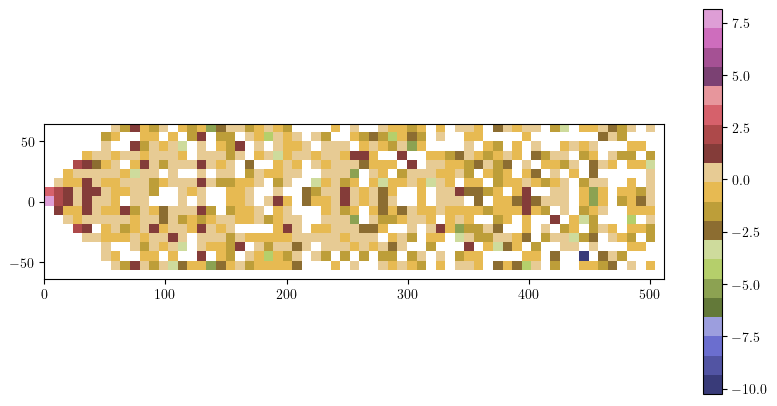

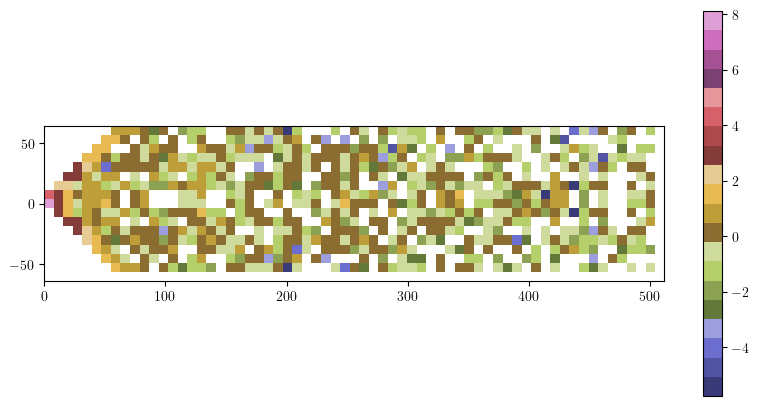

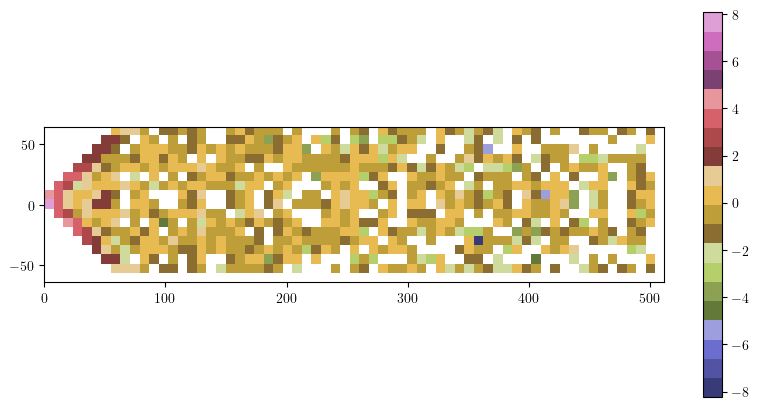

In [13]:
for zzz, (multiplier, threshold) in enumerate(zip(list_multiplier, list_threshold)):
    plot_2d_corr(multiplier, threshold, xrange, trange, smoothing)
